## The objectives of this notebook is to implement a deep Neural Network model that:
    - uses all the data from private and public companies
    - predicts the total revenue for a company for a period of time based on the former period
## It is divided into three main parts:
    - Data agregation where we agregate data of income and balance sheets for private and public companies
    - The baseline neural network model which is a neural network with one layer of one neurone
    - The clustering and over-sampling of the data in order to improve the baseline model
    - The deep neural network model implementation
    

In [1]:
'''
We import the libraries necessary for the task
We include some functions written in the src/data


'''

import pandas as pd
import numpy as np
import sys
import os
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Import the function
sys.path.append(os.path.abspath('../src/data'))
from extract_for_model_new import extract_time_series
from extract_for_model_new import scale_time_series_all
from extract_for_model_choosen_shift import extract_time_series_choosen_shift
%matplotlib inline

## Get the file and the features for the software private income statements
    
    This will give a dataframe with all the data for 4 features:
        - The Earnings before interest and taxes
        - The Operating income
        - The total revenue
        - The total other operating income
    
    The total revenue will be shifted for one period
  

In [2]:
input_path = '/home/reference/data_interim/software_private_annual_revised_income_statements_INTERIM.csv'
#features   = [ 'IQ_TOTAL_OTHER_OPER','IQ_NI','IQ_GP',
#              'IQ_OPER_INC','IQ_EBITDA','IQ_EARNING_CO','IQ_OTHER_OPER',
#              'IQ_INC_TAX','IQ_NET_INTEREST_EXP','IQ_TOTAL_REV']
features = [ 'IQ_EBIT',
              'IQ_TOTAL_OTHER_OPER',
              'IQ_OPER_INC','IQ_TOTAL_REV']
features_to_shift = ['IQ_TOTAL_REV']
ids        = []
#year_min   = 2014
steps      = 0
unitshift = 2
train_df_ps, test_df_ps = extract_time_series_choosen_shift(input_path = input_path,
                                   features = features,
                                    features_to_shift = features_to_shift,
                                      steps = steps,
                                 unitshift = 2
                                 
                                
                                )
dataset_private_soft = pd.concat([train_df_ps,test_df_ps])


#dataset_scale = scale_time_series_all(dataset,features,'standard')

Size BEFORE dropping NA: (2799, 8)
Size AFTER dropping NA: (2505, 8)
TEST  set size: (271, 8)
TRAIN set size: (2234, 8)
TEST is 11% of all available datapoints


In [3]:
dataset_private_soft.head()

,company,year,quarter,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV+0,IQ_TOTAL_REV+1
0,IQ10127723,2010.0,Q4,0.124289,0.718861,0.124289,0.853228,1.215607
1,IQ10127723,2011.0,Q4,0.313345,0.881659,0.313345,1.215607,2.796777
2,IQ10127723,2015.0,Q4,0.640532,2.020247,0.640532,2.796777,3.040088
3,IQ10127723,2016.0,Q4,-0.010990,2.903132,-0.010990,3.040088,5.158841
6,IQ102267046,2013.0,Q4,0.088781,1.544846,0.088781,2.962316,4.305274


## Get the file and balance sheets features for the software private companies
    
    This will give a dataframe with all the data for 4 features:
        - The Total assets of the companies 
        - The Account receivable
        - The Retained earnings
        
    
  

In [4]:
input_path_bal = '/home/reference/data_interim/software_private_annual_revised_balance_sheets_INTERIM.csv'
#features   = [ 'IQ_TOTAL_OTHER_OPER','IQ_NI','IQ_GP',
#              'IQ_OPER_INC','IQ_EBITDA','IQ_EARNING_CO','IQ_OTHER_OPER',
#              'IQ_INC_TAX','IQ_NET_INTEREST_EXP','IQ_TOTAL_REV']
features_bal = [ 'IQ_AR','IQ_RE','IQ_TOTAL_ASSETS']
ids        = []
#year_min   = 2014
steps      = 0
unitshift = 0
train_bal_ps_df, test_bal_ps_df = extract_time_series_choosen_shift(input_path = input_path_bal,
                                   features = features_bal,
                                    
                                      steps = steps,
                                 unitshift = 0
                                 
                                
                                )
dataset_bal_ps = pd.concat([train_bal_ps_df,test_bal_ps_df])


#dataset_scale_bal = scale_time_series_all(dataset_bal,features_bal,'standard')

Size BEFORE dropping NA: (2800, 6)
Size AFTER dropping NA: (1508, 6)
TEST  set size: (163, 6)
TRAIN set size: (1345, 6)
TEST is 11% of all available datapoints


In [5]:
dataset_bal_ps.head()

,company,year,quarter,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS
6,IQ102267046,2013.0,Q4,2.467916,-0.220824,3.479154
7,IQ102267046,2014.0,Q4,3.671694,0.081069,4.908565
8,IQ102267046,2015.0,Q4,5.159870,0.107997,6.973966
9,IQ102267046,2016.0,Q4,9.834407,0.471308,13.360882
29,IQ105654219,2007.0,Q4,0.736371,-0.161029,1.867177


In [6]:
## Merge the income and balanced datasets for software private companies based on company and year

In [7]:
dataset_ps = dataset_private_soft.merge(dataset_bal_ps,on = ['company','year'])

In [8]:
dataset_ps = dataset_ps.drop(['quarter_y'],axis=1)
dataset_ps = dataset_ps.rename(columns={'quarter_x':'quarter'})

In [9]:
dataset_ps.head()

,company,year,quarter,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV+0,IQ_TOTAL_REV+1,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS
0,IQ102267046,2013.0,Q4,0.088781,1.544846,0.088781,2.962316,4.305274,2.467916,-0.220824,3.479154
1,IQ102267046,2014.0,Q4,0.161020,2.177063,0.161020,4.305274,6.537584,3.671694,0.081069,4.908565
2,IQ102267046,2015.0,Q4,0.018564,3.163827,0.018564,6.537584,12.468611,5.159870,0.107997,6.973966
3,IQ105654219,2007.0,Q4,-0.058002,1.405880,-0.058002,2.912760,4.642862,0.736371,-0.161029,1.867177
4,IQ105654219,2012.0,Q4,0.417684,1.918909,0.417684,4.642862,4.957326,1.114145,0.935905,3.141921


In [10]:
dataset_ps.describe()

,year,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV+0,IQ_TOTAL_REV+1,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS
count,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000
mean,2011.305638,1.648386,11.023697,1.648386,32.678310,36.617324,11.592821,0.255308,36.131715
std,4.388187,10.133301,21.520183,10.133301,96.394940,109.210370,51.658306,33.496027,128.859574
min,1995.000000,-69.247000,-10.890000,-69.247000,0.011290,0.069882,0.000703,-156.631000,0.028000
25%,2008.000000,-0.295733,2.672286,-0.295733,3.906900,4.495687,0.831730,-2.502410,3.506687
50%,2012.000000,0.226677,5.128566,0.226677,7.969803,9.009022,1.907658,0.117501,7.323302
75%,2015.000000,1.127429,10.973280,1.127429,18.437854,20.747903,4.515668,1.395056,18.051230
max,2017.000000,113.530655,305.577760,113.530655,1005.543950,1252.778000,622.901200,581.823850,1781.078900


## Get the file and the features for the health private income statements
    
    This will give a dataframe with all the data for 4 features:
        - The Earnings before interest and taxes
        - The Operating income
        - The total revenue
        - The total other operating income
    
    The total revenue will be shifted for one period
  

In [11]:
input_path = '/home/reference/data_interim/health_private_annual_revised_income_statements_INTERIM.csv'
#features   = [ 'IQ_TOTAL_OTHER_OPER','IQ_NI','IQ_GP',
#              'IQ_OPER_INC','IQ_EBITDA','IQ_EARNING_CO','IQ_OTHER_OPER',
#              'IQ_INC_TAX','IQ_NET_INTEREST_EXP','IQ_TOTAL_REV']
features = [ 'IQ_EBIT',
              'IQ_TOTAL_OTHER_OPER',
              'IQ_OPER_INC','IQ_TOTAL_REV']
features_to_shift = ['IQ_TOTAL_REV']
ids        = []
#year_min   = 2014
steps      = 0
unitshift = 2
train_df_prh, test_df_prh = extract_time_series_choosen_shift(input_path = input_path,
                                   features = features,
                                    features_to_shift = features_to_shift,
                                      steps = steps,
                                 unitshift = 2
                                 
                                
                                )
dataset_prh = pd.concat([train_df_prh,test_df_prh])


#dataset_scale = scale_time_series_all(dataset,features,'standard')

Size BEFORE dropping NA: (2872, 8)
Size AFTER dropping NA: (2567, 8)
TEST  set size: (278, 8)
TRAIN set size: (2289, 8)
TEST is 11% of all available datapoints


In [12]:
dataset_prh.head()

,company,year,quarter,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV+0,IQ_TOTAL_REV+1
0,IQ1001166,2000.0,Q4,-0.524020,0.590363,-0.524020,0.078805,0.310828
1,IQ1001166,2001.0,Q4,-3.144316,3.455144,-3.144316,0.310828,1.679933
2,IQ1001166,2002.0,Q4,-4.693309,6.373243,-4.693309,1.679933,0.618198
3,IQ1001166,2003.0,Q4,-6.217653,6.835851,-6.217653,0.618198,0.851750
4,IQ1001166,2004.0,Q4,-5.655608,6.507358,-5.655608,0.851750,0.953738


## Get the file and balance sheets features for the health private companies
    
    This will give a dataframe with all the data for 3 features:
        - The Total assets of the companies 
        - The Account receivable
        - The Retained earnings
        
    
  

In [13]:
input_path_bal = '/home/reference/data_interim/health_private_annual_revised_balance_sheets_INTERIM.csv'
#features   = [ 'IQ_TOTAL_OTHER_OPER','IQ_NI','IQ_GP',
#              'IQ_OPER_INC','IQ_EBITDA','IQ_EARNING_CO','IQ_OTHER_OPER',
#              'IQ_INC_TAX','IQ_NET_INTEREST_EXP','IQ_TOTAL_REV']
features_bal = [ 'IQ_AR','IQ_RE','IQ_TOTAL_ASSETS']
ids        = []
#year_min   = 2014
steps      = 0
unitshift = 0
train_bal_prh_df, test_bal_prh_df = extract_time_series_choosen_shift(input_path = input_path_bal,
                                   features = features_bal,
                                    
                                      steps = steps,
                                 unitshift = 0
                                 
                                
                                )
dataset_bal_prh = pd.concat([train_bal_prh_df,test_bal_prh_df])


#dataset_scale_bal = scale_time_series_all(dataset_bal,features_bal,'standard')

Size BEFORE dropping NA: (2869, 6)
Size AFTER dropping NA: (1866, 6)
TEST  set size: (198, 6)
TRAIN set size: (1668, 6)
TEST is 11% of all available datapoints


In [14]:
# Merge the datasets for private health companies based on company and year

In [15]:
dataset_prh = dataset_prh.merge(dataset_bal_prh,on = ['company','year'])

In [16]:
dataset_prh.head()

,company,year,quarter_x,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV+0,IQ_TOTAL_REV+1,quarter_y,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS
0,IQ1001166,2001.0,Q4,-3.144316,3.455144,-3.144316,0.310828,1.679933,Q4,0.390459,-3.507091,12.080082
1,IQ1001166,2003.0,Q4,-6.217653,6.835851,-6.217653,0.618198,0.851750,Q4,0.032795,-7.022183,14.375587
2,IQ1001166,2004.0,Q4,-5.655608,6.507358,-5.655608,0.851750,0.953738,Q4,0.016044,-21.522116,8.576273
3,IQ1001166,2005.0,Q4,-5.098989,6.052727,-5.098989,0.953738,1.248193,Q4,0.010995,-25.190521,4.775652
4,IQ1001166,2006.0,Q4,-7.037172,8.285365,-7.037172,1.248193,2.101235,Q4,0.218077,-32.030760,5.160438


In [17]:
dataset_prh = dataset_prh.drop(['quarter_y'],axis=1)
dataset_prh = dataset_prh.rename(columns = {'quarter_x':'quarter'})

In [18]:
dataset_prh.head()

,company,year,quarter,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV+0,IQ_TOTAL_REV+1,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS
0,IQ1001166,2001.0,Q4,-3.144316,3.455144,-3.144316,0.310828,1.679933,0.390459,-3.507091,12.080082
1,IQ1001166,2003.0,Q4,-6.217653,6.835851,-6.217653,0.618198,0.851750,0.032795,-7.022183,14.375587
2,IQ1001166,2004.0,Q4,-5.655608,6.507358,-5.655608,0.851750,0.953738,0.016044,-21.522116,8.576273
3,IQ1001166,2005.0,Q4,-5.098989,6.052727,-5.098989,0.953738,1.248193,0.010995,-25.190521,4.775652
4,IQ1001166,2006.0,Q4,-7.037172,8.285365,-7.037172,1.248193,2.101235,0.218077,-32.030760,5.160438


In [19]:
dataset_p = pd.concat([dataset_ps,dataset_prh],axis=0,ignore_index=True)

In [20]:
dataset_p.head()

,company,year,quarter,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV+0,IQ_TOTAL_REV+1,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS
0,IQ102267046,2013.0,Q4,0.088781,1.544846,0.088781,2.962316,4.305274,2.467916,-0.220824,3.479154
1,IQ102267046,2014.0,Q4,0.161020,2.177063,0.161020,4.305274,6.537584,3.671694,0.081069,4.908565
2,IQ102267046,2015.0,Q4,0.018564,3.163827,0.018564,6.537584,12.468611,5.159870,0.107997,6.973966
3,IQ105654219,2007.0,Q4,-0.058002,1.405880,-0.058002,2.912760,4.642862,0.736371,-0.161029,1.867177
4,IQ105654219,2012.0,Q4,0.417684,1.918909,0.417684,4.642862,4.957326,1.114145,0.935905,3.141921


In [21]:
dataset_p.describe()

,year,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV+0,IQ_TOTAL_REV+1,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS
count,3012.000000,3012.000000,3012.000000,3012.000000,3012.000000,3012.000000,3012.000000,3012.000000,3012.000000
mean,2011.354250,6.791917,24.218951,6.791917,65.126741,78.277634,14.142430,2.283245,111.353033
std,4.395698,88.575264,156.763161,88.575264,456.569126,606.202716,81.507723,196.034359,1395.443544
min,1989.000000,-69.247000,-10.890000,-69.247000,0.004981,0.011503,0.000277,-1151.897000,0.028000
25%,2009.000000,-0.245345,2.949947,-0.245345,5.059110,5.811021,0.845760,-2.710970,5.129623
50%,2012.000000,0.434824,5.882072,0.434824,11.067161,12.364086,2.101464,0.200630,11.467958
75%,2015.000000,1.977820,13.784563,1.977820,26.148760,28.247320,5.464332,2.350529,37.737479
max,2017.000000,3081.475300,5210.468000,3081.475300,16088.604000,18481.367000,2303.079000,7339.756000,54293.312000


## Repeat the same process  as above for public data 

## Get the file and the features for the software public income statements
    
    This will give a dataframe with all the data for 4 features:
        - The Earnings before interest and taxes
        - The Operating income
        - The total revenue
        - The total other operating income
    
    The total revenue will be shifted for one period
  

In [22]:
input_path = '/home/reference/data_interim/software_public_quarterly_revised_income_statements_INTERIM.csv'
#features   = [ 'IQ_TOTAL_OTHER_OPER','IQ_NI','IQ_GP',
#              'IQ_OPER_INC','IQ_EBITDA','IQ_EARNING_CO','IQ_OTHER_OPER',
#              'IQ_INC_TAX','IQ_NET_INTEREST_EXP','IQ_TOTAL_REV']
features = [ 'IQ_EBIT',
              'IQ_TOTAL_OTHER_OPER',
              'IQ_OPER_INC','IQ_TOTAL_REV']
features_to_shift = ['IQ_TOTAL_REV']
ids        = []
#year_min   = 2014
steps      = 0
unitshift = 2
train_df_pus, test_df_pus = extract_time_series_choosen_shift(input_path = input_path,
                                   features = features,
                                    features_to_shift = features_to_shift,
                                      steps = steps,
                                 unitshift = 2
                                 
                                
                                )
dataset_public_soft = pd.concat([train_df_pus,test_df_pus])


#dataset_scale = scale_time_series_all(dataset,features,'standard')

Size BEFORE dropping NA: (4508, 8)
Size AFTER dropping NA: (3796, 8)
TEST  set size: (560, 8)
TRAIN set size: (3236, 8)
TEST is 15% of all available datapoints


In [23]:
dataset_public_soft.quarter.unique()

array(['Q4', 'Q3', 'Q2', 'Q1'], dtype=object)

## Get the file and the features for the health public income statements
    
    This will give a dataframe with all the data for 4 features:
        - The Earnings before interest and taxes
        - The Operating income
        - The total revenue
        - The total other operating income
    
    The total revenue will be shifted for one period
  

In [24]:
input_path = '/home/reference/data_interim/health_public_quarterly_revised_income_statements_INTERIM.csv'
#features   = [ 'IQ_TOTAL_OTHER_OPER','IQ_NI','IQ_GP',
#              'IQ_OPER_INC','IQ_EBITDA','IQ_EARNING_CO','IQ_OTHER_OPER',
#              'IQ_INC_TAX','IQ_NET_INTEREST_EXP','IQ_TOTAL_REV']
features = [ 'IQ_EBIT',
              'IQ_TOTAL_OTHER_OPER',
              'IQ_OPER_INC','IQ_TOTAL_REV']
features_to_shift = ['IQ_TOTAL_REV']
ids        = []
#year_min   = 2014
steps      = 0
unitshift = 2
train_df_puh, test_df_puh = extract_time_series_choosen_shift(input_path = input_path,
                                   features = features,
                                    features_to_shift = features_to_shift,
                                      steps = steps,
                                 unitshift = 2
                                 
                                
                                )
dataset_public_health = pd.concat([train_df_puh,test_df_puh])


#dataset_scale = scale_time_series_all(dataset,features,'standard')

Size BEFORE dropping NA: (3913, 8)
Size AFTER dropping NA: (3393, 8)
TEST  set size: (449, 8)
TRAIN set size: (2944, 8)
TEST is 13% of all available datapoints


In [25]:
dataset_public_health['quarter'].unique()

array(['Q4', 'Q2', 'Q3', 'Q1'], dtype=object)

## Get the file and balance sheets features for the software public companies
    
    This will give a dataframe with all the data for 3 features:
        - The Total assets of the companies 
        - The Account receivable
        - The Retained earnings
        
    
  

In [26]:
input_path_bal = '/home/reference/data_interim/software_public_quarterly_revised_balance_sheets_INTERIM.csv'
#features   = [ 'IQ_TOTAL_OTHER_OPER','IQ_NI','IQ_GP',
#              'IQ_OPER_INC','IQ_EBITDA','IQ_EARNING_CO','IQ_OTHER_OPER',
#              'IQ_INC_TAX','IQ_NET_INTEREST_EXP','IQ_TOTAL_REV']
features_bal = [ 'IQ_AR','IQ_RE','IQ_TOTAL_ASSETS']
ids        = []
#year_min   = 2014
steps      = 0
unitshift = 0
train_bal_pus_df, test_bal_pus_df = extract_time_series_choosen_shift(input_path = input_path_bal,
                                   features = features_bal,
                                    
                                      steps = steps,
                                 unitshift = 0
                                 
                                
                                )
dataset_bal_pus = pd.concat([train_bal_pus_df,test_bal_pus_df])


#dataset_scale_bal = scale_time_series_all(dataset_bal,features_bal,'standard')

Size BEFORE dropping NA: (4482, 6)
Size AFTER dropping NA: (4103, 6)
TEST  set size: (560, 6)
TRAIN set size: (3543, 6)
TEST is 14% of all available datapoints


In [27]:
#dataset_bal_pus = pd.concat([dataset_bal_pus1,dataset_bal_pus2,dataset_bal_pus3],axis = 0)

In [28]:
dataset_bal_pus.head()

,company,year,quarter,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS
0,IQ1004737,2008.0,Q4,51.364550,9.630161,142.18341
1,IQ1004737,2009.0,Q4,54.929703,12.275393,141.91211
2,IQ1004737,2010.0,Q4,61.973870,14.743946,149.75757
3,IQ1004737,2011.0,Q4,72.820300,10.702577,165.16977
4,IQ1004737,2012.0,Q4,63.937496,10.904575,151.79121


In [29]:
## Merge the public income and balance sheet data based on company, year and quarter

In [30]:
dataset_pus = dataset_public_soft.merge(dataset_bal_pus, on = ['company','year','quarter'])

In [31]:
dataset_pus.describe()

,year,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV+0,IQ_TOTAL_REV+1,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS
count,3413.000000,3413.000000,3413.000000,3413.000000,3413.000000,3413.000000,3413.000000,3413.000000,3413.000000
mean,2012.237621,10.217009,17.758383,10.217009,72.095352,78.388366,64.271539,78.586346,296.179196
std,3.946606,83.493527,117.637969,83.493527,402.370530,438.574018,327.711734,814.499529,1740.763198
min,1995.000000,-382.351930,-301.157650,-382.351930,-64.661670,-11.126720,0.000000,-690.700000,0.006726
25%,2010.000000,-0.062956,0.430961,-0.062956,1.335637,1.479961,1.163760,-2.775463,6.144484
50%,2013.000000,0.296677,1.467443,0.296677,5.105000,5.532261,4.589000,0.809295,20.525528
75%,2015.000000,1.794069,4.588644,1.794069,21.656979,22.612963,18.196371,8.146409,78.848885
max,2017.000000,1468.934100,2856.169200,1468.934100,7317.752400,8309.657000,5521.422400,22004.496000,37855.832000


## Get the file and balance sheets features for the health public companies
    
    This will give a dataframe with all the data for 3 features:
        - The Total assets of the companies 
        - The Account receivable
        - The Retained earnings
        
    
  

In [32]:
input_path_bal = '/home/reference/data_interim/health_public_quarterly_revised_balance_sheets_INTERIM.csv'
#features   = [ 'IQ_TOTAL_OTHER_OPER','IQ_NI','IQ_GP',
#              'IQ_OPER_INC','IQ_EBITDA','IQ_EARNING_CO','IQ_OTHER_OPER',
#              'IQ_INC_TAX','IQ_NET_INTEREST_EXP','IQ_TOTAL_REV']
features_bal = [ 'IQ_AR','IQ_RE','IQ_TOTAL_ASSETS']
ids        = []
#year_min   = 2014
steps      = 0
unitshift = 0
train_bal_puh1_df, test_bal_puh1_df = extract_time_series_choosen_shift(input_path = input_path_bal,
                                   features = features_bal,
                                    
                                      steps = steps,
                                 unitshift = 0
                                 
                                
                                )
dataset_bal_puh1 = pd.concat([train_bal_puh1_df,test_bal_puh1_df])


#dataset_scale_bal = scale_time_series_all(dataset_bal,features_bal,'standard')

Size BEFORE dropping NA: (3905, 6)
Size AFTER dropping NA: (3582, 6)
TEST  set size: (441, 6)
TRAIN set size: (3141, 6)
TEST is 12% of all available datapoints


In [33]:
dataset_puh = dataset_public_health.merge(dataset_bal_puh1, on = ['company','year','quarter'])

In [34]:
dataset_puh.quarter.describe()

count     3038
unique       4
top         Q4
freq      2998
Name: quarter, dtype: object

In [35]:
dataset_pu = pd.concat([dataset_pus, dataset_puh], axis= 0)

In [36]:
dataset_pu.describe()

,year,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV+0,IQ_TOTAL_REV+1,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS
count,6451.000000,6451.000000,6451.000000,6451.000000,6451.000000,6451.000000,6451.000000,6451.000000,6451.000000
mean,2012.594481,28.564296,60.710916,28.564296,170.796120,180.614976,128.583304,283.777474,1048.524192
std,3.526493,186.911611,345.372630,186.911611,830.811782,866.517471,605.482713,2421.247662,6011.921586
min,1995.000000,-382.351930,-301.157650,-382.351930,-64.661670,-11.126720,0.000000,-6920.000000,0.006726
25%,2010.000000,-0.216345,0.699123,-0.216345,1.440951,1.566924,1.132342,-5.559749,8.702160
50%,2013.000000,0.300508,2.369944,0.300508,6.100487,6.623017,4.949204,0.736875,32.026924
75%,2015.000000,3.023458,10.220679,3.023458,32.422404,35.023761,27.830761,16.815114,152.542875
max,2017.000000,3916.000000,4848.000000,3916.000000,10703.440000,11949.044000,9378.246000,65723.390000,105390.030000


In [37]:
#Mark rows for private companies with 0 and public companies with one
dataset_p.insert(11,'IQ_CATEGORY',np.zeros(dataset_p.shape[0]),True)
dataset_pu.insert(11,'IQ_CATEGORY',np.ones(dataset_pu.shape[0]),True)

In [38]:
dataset_pu.head()

,company,year,quarter,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV+0,IQ_TOTAL_REV+1,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS,IQ_CATEGORY
0,IQ1004737,2008.0,Q4,4.715592,0.587953,4.715592,27.367480,24.618883,51.364550,9.630161,142.18341,1.0
1,IQ1004737,2009.0,Q4,3.819487,2.139208,3.819487,24.618883,23.524069,54.929703,12.275393,141.91211,1.0
2,IQ1004737,2010.0,Q4,3.458828,2.173012,3.458828,23.524069,30.077684,61.973870,14.743946,149.75757,1.0
3,IQ1004737,2011.0,Q4,4.357645,3.713942,4.357645,30.077684,32.529490,72.820300,10.702577,165.16977,1.0
4,IQ1004737,2012.0,Q4,3.101893,4.942206,3.101893,32.529490,30.630005,63.937496,10.904575,151.79121,1.0


## Merge all the data from public and private

In [39]:

dataset_all = pd.concat([dataset_p,dataset_pu], axis = 0)

In [40]:
dataset_all.describe()

,year,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV+0,IQ_TOTAL_REV+1,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS,IQ_CATEGORY
count,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000
mean,2012.199725,21.634315,49.095804,21.634315,137.162371,148.041788,92.157655,194.180029,750.229832,0.681708
std,3.867802,162.525140,299.033042,162.525140,734.358299,794.386244,504.840784,2006.414160,5044.614430,0.465838
min,1989.000000,-382.351930,-301.157650,-382.351930,-64.661670,-11.126720,0.000000,-6920.000000,0.006726,0.000000
25%,2010.000000,-0.223713,1.128921,-0.223713,2.225366,2.532351,0.986781,-4.513678,6.836584,0.000000
50%,2013.000000,0.345882,3.524000,0.345882,8.082776,8.914500,3.357951,0.391380,22.646652,1.000000
75%,2015.000000,2.508452,11.899054,2.508452,29.223067,31.623048,16.231681,8.494703,100.562075,1.000000
max,2017.000000,3916.000000,5210.468000,3916.000000,16088.604000,18481.367000,9378.246000,65723.390000,105390.030000,1.000000


In [41]:
dataset_all['IQ_CATEGORY'] = pd.Categorical(dataset_all.IQ_CATEGORY)

In [42]:
dataset_all = dataset_all.rename(columns={'IQ_TOTAL_REV+0':'IQ_TOTAL_REV','IQ_TOTAL_REV+1':'TARGET'})

In [43]:
dataset_all.head()

,company,year,quarter,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV,TARGET,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS,IQ_CATEGORY
0,IQ102267046,2013.0,Q4,0.088781,1.544846,0.088781,2.962316,4.305274,2.467916,-0.220824,3.479154,0.0
1,IQ102267046,2014.0,Q4,0.161020,2.177063,0.161020,4.305274,6.537584,3.671694,0.081069,4.908565,0.0
2,IQ102267046,2015.0,Q4,0.018564,3.163827,0.018564,6.537584,12.468611,5.159870,0.107997,6.973966,0.0
3,IQ105654219,2007.0,Q4,-0.058002,1.405880,-0.058002,2.912760,4.642862,0.736371,-0.161029,1.867177,0.0
4,IQ105654219,2012.0,Q4,0.417684,1.918909,0.417684,4.642862,4.957326,1.114145,0.935905,3.141921,0.0


In [44]:
# Generate a dataset based on the merged data
dataset_all.to_csv(r'private_public_file.csv')

In [45]:
dataset_all.head()

,company,year,quarter,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV,TARGET,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS,IQ_CATEGORY
0,IQ102267046,2013.0,Q4,0.088781,1.544846,0.088781,2.962316,4.305274,2.467916,-0.220824,3.479154,0.0
1,IQ102267046,2014.0,Q4,0.161020,2.177063,0.161020,4.305274,6.537584,3.671694,0.081069,4.908565,0.0
2,IQ102267046,2015.0,Q4,0.018564,3.163827,0.018564,6.537584,12.468611,5.159870,0.107997,6.973966,0.0
3,IQ105654219,2007.0,Q4,-0.058002,1.405880,-0.058002,2.912760,4.642862,0.736371,-0.161029,1.867177,0.0
4,IQ105654219,2012.0,Q4,0.417684,1.918909,0.417684,4.642862,4.957326,1.114145,0.935905,3.141921,0.0


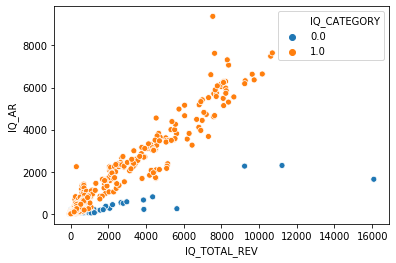

In [46]:
sns.scatterplot(x = dataset_all['IQ_TOTAL_REV'],y = dataset_all['IQ_AR'],hue = 'IQ_CATEGORY', data = dataset_all)

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import metrics
X = pd.get_dummies(dataset_all[["IQ_CATEGORY"]],sparse = False)

dataset_all.insert(12,"IQ_PRIV",X['IQ_CATEGORY_0.0'],True)
dataset_all.insert(13,"IQ_PUB",X['IQ_CATEGORY_1.0'],True)
#dataset.rename(columns={"0.0":"IQ_PRIVATE","1.0":"IQ_PUBLIC"})

In [48]:
dataset_all.describe()

,year,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV,TARGET,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS,IQ_PRIV,IQ_PUB
count,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000
mean,2012.199725,21.634315,49.095804,21.634315,137.162371,148.041788,92.157655,194.180029,750.229832,0.318292,0.681708
std,3.867802,162.525140,299.033042,162.525140,734.358299,794.386244,504.840784,2006.414160,5044.614430,0.465838,0.465838
min,1989.000000,-382.351930,-301.157650,-382.351930,-64.661670,-11.126720,0.000000,-6920.000000,0.006726,0.000000,0.000000
25%,2010.000000,-0.223713,1.128921,-0.223713,2.225366,2.532351,0.986781,-4.513678,6.836584,0.000000,0.000000
50%,2013.000000,0.345882,3.524000,0.345882,8.082776,8.914500,3.357951,0.391380,22.646652,0.000000,1.000000
75%,2015.000000,2.508452,11.899054,2.508452,29.223067,31.623048,16.231681,8.494703,100.562075,1.000000,1.000000
max,2017.000000,3916.000000,5210.468000,3916.000000,16088.604000,18481.367000,9378.246000,65723.390000,105390.030000,1.000000,1.000000


In [49]:
dataset_all = dataset_all.drop(['IQ_CATEGORY'], axis = 1)

In [50]:
dataset_all.head()

,company,year,quarter,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV,TARGET,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS,IQ_PRIV,IQ_PUB
0,IQ102267046,2013.0,Q4,0.088781,1.544846,0.088781,2.962316,4.305274,2.467916,-0.220824,3.479154,1,0
1,IQ102267046,2014.0,Q4,0.161020,2.177063,0.161020,4.305274,6.537584,3.671694,0.081069,4.908565,1,0
2,IQ102267046,2015.0,Q4,0.018564,3.163827,0.018564,6.537584,12.468611,5.159870,0.107997,6.973966,1,0
3,IQ105654219,2007.0,Q4,-0.058002,1.405880,-0.058002,2.912760,4.642862,0.736371,-0.161029,1.867177,1,0
4,IQ105654219,2012.0,Q4,0.417684,1.918909,0.417684,4.642862,4.957326,1.114145,0.935905,3.141921,1,0


## Create a csv file for all the data

In [51]:
dataset_all.to_csv(r'pivate_public_file.csv')

## Split the data into training and test sets
    - Create the standard scaler for the training part
    - Create the standard scaler for the target part
    - Scale the training data and apply it to the test data
    - Train the target data and apply it to test target

In [52]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()


X_train,X_test = train_test_split(dataset_all,random_state=0)
#plt.rcParams["figure.figsize"]=40,40

In [53]:
# Drop the scaling of Target
y_train = X_train['TARGET']
y_test = X_test['TARGET']
X_train.drop('TARGET',axis=1,inplace = True)
X_test.drop('TARGET',axis=1, inplace = True)

/home/mbousso/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [54]:
#Drop Target and scale the train and test set

X_train_scale = scaler_X.fit_transform(X_train.loc[:,"IQ_EBIT":"IQ_TOTAL_ASSETS"])
X_test_scale = scaler_X.transform(X_test.loc[:,"IQ_EBIT":"IQ_TOTAL_ASSETS"])


# Create a new dataframe based on this scale train data and scale test data

X_train_scale = pd.DataFrame(X_train_scale)
X_train_scale.columns = X_train.columns[3:10]
X_test_scale = pd.DataFrame(X_test_scale)
X_test_scale.columns = X_test.columns[3:10]

# Insert the company, the year and the quarter to this new dataframes
X_train_scale.insert(0,'company',X_train['company'].values,True)
X_train_scale.insert(1,'year',X_train['year'].values,False)
X_train_scale.insert(2,'quarter',X_train['quarter'].values,False)


X_train_scale.insert(10,'IQ_PRIV',X_train['IQ_PRIV'].values,False)
X_train_scale.insert(11,'IQ_PUB',X_train['IQ_PUB'].values,False)

X_test_scale.insert(0,'company',X_test['company'].values,False)
X_test_scale.insert(1,'year',X_test['year'].values,False)
X_test_scale.insert(2,'quarter',X_test['quarter'].values,False)

X_test_scale.insert(10,'IQ_PRIV',X_test['IQ_PRIV'].values,False)
X_test_scale.insert(11,'IQ_PUB',X_test['IQ_PUB'].values,False)


In [55]:
#Scale the target train and test variable

y_train = y_train.values.reshape(len(y_train),1)
y_test = y_test.values.reshape(len(y_test),1)
y_train_scale = scaler_y.fit_transform(y_train)
y_test_scale = scaler_y.transform(y_test)

# Create a new dataframe based on this scale train data and scale test data

y_train_scale = pd.DataFrame(y_train_scale)
y_train_scale.columns = {'TARGET'}
y_test_scale = pd.DataFrame(y_test_scale)
y_test_scale.columns = {'TARGET'}

y_train = pd.DataFrame(y_train)
y_train.columns = {'TARGET'}

y_test = pd.DataFrame(y_test)
y_test.columns = {'TARGET'}

In [56]:

X_train_scale.head()

,company,year,quarter,IQ_EBIT,IQ_TOTAL_OTHER_OPER,IQ_OPER_INC,IQ_TOTAL_REV,IQ_AR,IQ_RE,IQ_TOTAL_ASSETS,IQ_PRIV,IQ_PUB
0,IQ9273142,2011.0,Q4,-0.131722,-0.167487,-0.131722,-0.178980,-0.176578,-0.100692,-0.151470,0,1
1,IQ1004737,2013.0,Q4,-0.116749,-0.152239,-0.116749,-0.149563,-0.072222,-0.097301,-0.122299,0,1
2,IQ2220050,2016.0,Q4,-0.135682,-0.157108,-0.135682,-0.186244,-0.187313,-0.102613,-0.153781,1,0
3,IQ117542163,2015.0,Q4,-0.132076,-0.167722,-0.132076,-0.189803,-0.187834,-0.103767,-0.153675,0,1
4,IQ83524843,2015.0,Q4,-0.134141,-0.167843,-0.134141,-0.189350,-0.186632,-0.103125,-0.153330,0,1


In [57]:
X_train_scale.loc[:,'IQ_EBIT':'IQ_PUB'].values

array([[-0.13172206, -0.1674869 , -0.13172206, ..., -0.15147009,
         0.        ,  1.        ],
       [-0.11674881, -0.15223906, -0.11674881, ..., -0.12229935,
         0.        ,  1.        ],
       [-0.13568224, -0.15710825, -0.13568224, ..., -0.15378136,
         1.        ,  0.        ],
       ...,
       [-0.12812175, -0.16839134, -0.12812175, ..., -0.15348356,
         0.        ,  1.        ],
       [-0.13469479, -0.15911   , -0.13469479, ..., -0.13651349,
         0.        ,  1.        ],
       [-0.14877486, -0.1382656 , -0.14877486, ..., -0.14678786,
         1.        ,  0.        ]])

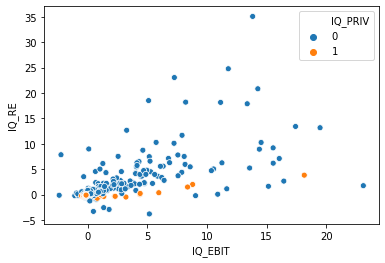

In [58]:
sns.scatterplot(x = 'IQ_EBIT', y = 'IQ_RE',hue = 'IQ_PRIV',data = X_train_scale)

In [59]:
# Install tensorflow 2.0
!pip install tf-nightly-2.0_preview

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.python.data import Dataset
import datetime

In [75]:
%reload_ext tensorboard

In [76]:
print(tf.__version__)

2.0.0


In [77]:
!rm -rf ./logs/

## Create a tensorflow Dataset for the tensorflow pipeline we will build

In [78]:

dataset = Dataset.from_tensor_slices((X_train_scale.loc[:,'IQ_EBIT':'IQ_PUB'].values,y_train_scale.values))


In [79]:
dataset = dataset.map(lambda window1, window2: ( window1,window2))
#for (window ,window2 )in dataset:
#    print(window.numpy(), window2.numpy())
dataset = dataset.shuffle(buffer_size = 10)
#Batching the data with size 80
dataset = dataset.batch(80).prefetch(1)
#for x,y in dataset:
#   print(x.numpy(),y.numpy())





## Creation of the baseline model
    - A one layer with one node neural net

In [104]:
#Linear regression with Tensorflow
l0 = Dense(1,input_shape=[9]) 
model = Sequential([l0])

## Searching for the best learning rate for the model

In [105]:
#Compilation of the model
listelr = [0.0031,0.00315,0.00319, 0.00312, 0.00313]
#listelr = [0.0001, 0.00012,0.000122,0.000125]
dictLoss = {}
for ls in listelr:
    model.compile(loss="mae",optimizer = SGD(lr= ls, momentum= 0.9),metrics = ['mse'])
    history = model.fit(dataset , epochs = 20,verbose = 0)
    dictLoss[ls]=history.history['loss']


## We got 0.0031  as the best learning rate and lanuch the model with it

In [117]:
#log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(loss="mae",optimizer = SGD(lr= 0.0031, momentum= 0.9),metrics = ['mse']) # callbacks = [tensorboard_callback])
history = model.fit(dataset , epochs = 20,verbose = 0)

In [118]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [119]:
#import pkg_resources

#for entry_point in pkg_resources.iter_entry_points('tensorboard_plugins'):
#   print(entry_point.dist)

In [121]:
#!pip install tb-nightly

In [115]:
#%tensorboard --logdir logs/fit

In [102]:
## Calculate the weights of the features and the bias

In [114]:
print("layer weight {}", format(l0.get_weights()))

layer weight {} [array([[-0.20248996],
       [ 0.0105119 ],
       [ 0.21698426],
       [ 0.94576484],
       [ 0.01067984],
       [-0.00971705],
       [-0.00296278],
       [-0.08933883],
       [-0.09186403]], dtype=float32), array([0.08485112], dtype=float32)]


## Forecast and rescaling of the data

In [ ]:
# Invert transform the forecast and test values
forecast = model.predict(X_test_scale.loc[:,'IQ_EBIT':'IQ_PUB'].values)  #.flatten()
forecast = scaler_y.inverse_transform(forecast)
y_test_invert = scaler_y.inverse_transform(y_test_scale.values).flatten()
#print(history.history.keys())

In [ ]:

forecast = forecast.flatten()


print(forecast)
print(y_test_invert)

## Plot of the forecast and the true revenue using a window T

In [ ]:
T = round(len(forecast)/10)
x = [i for i in range(T)]
sns.set_context("notebook")
sns.set_style("darkgrid")
plt.figure(figsize=(15,10))
sns.lineplot(x,forecast[0:T])
sns.lineplot(x,y_test_invert[0:T].flatten())

## Plot of all forecast and true revenue data

In [ ]:
#T = round(len(forecast)/3)
x = [i for i in range(len(forecast))]
sns.set_context("notebook")
sns.set_style("darkgrid")
plt.figure(figsize=(10,10))
sns.lineplot(x,forecast)
sns.lineplot(x,y_test_invert)

## Calculate the metrics for evalautaion of the model

In [ ]:
train_mae = model.evaluate(X_train_scale.loc[:,"IQ_EBIT":"IQ_PUB"].values,y_train_scale.values,verbose = 0)

In [ ]:
test_mae = model.evaluate(X_test_scale.loc[:,"IQ_EBIT":"IQ_PUB"].values,y_test_scale.values,verbose = 0)

In [ ]:
print("training MAE", train_mae)
print("testing MAE", test_mae)

## Evaluate the performance of the training model by plotting the loss curve

In [ ]:
from matplotlib import pyplot
#Plot the loss during Training and Test
pyplot.title("Training  performances")
pyplot.plot(history.history['loss'], label ="Training")
#pyplot.plot(history.history['val_loss'], label ="Testing")
pyplot.legend()
pyplot.show()

## Calculate three metrics on the non scaled data:
    - The Mean Absolute Error
    - The Mean Absolute Percentage Error
    - The Mean Squared Error
    - The r2 score

In [ ]:
tf.keras.metrics.mean_absolute_error(forecast,y_test_invert).numpy()

In [ ]:
tf.keras.metrics.mean_absolute_percentage_error(forecast,y_test_invert).numpy()

In [ ]:
tf.keras.losses.mse(forecast,y_test_invert).numpy()

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(forecast,y_test_invert))

## Two Utility functions that help building the errors between the forecast and real revenus

In [ ]:
def df_forecast(df,features_to_drop,features_to_add1,features_to_add2,df_to_add1, df_to_add2):
    df.drop(features_to_drop,axis = 1, inplace = True)
    df[features_to_add1] = df_to_add1
    df[features_to_add2] = df_to_add2
    return df


In [ ]:
def error_data(df,errors,true_values,forecast):
    df[errors] = np.abs(np.abs(df.loc[:,true_values]) - np.abs(df.loc[:,forecast]))
    return df


## Build a new Dataframe that contains:
    - The companies column
    - The year column
    - Two columns indicating if the company is public or private
    - The true revenue
    - The forecast revenue
    - The absulte error between the absolute values of the forecast and the true revenus

In [ ]:
df_X_test_copy = X_test_scale.copy(deep = True)

In [ ]:
df_X_test_copy = df_forecast(df_X_test_copy,features + features_bal,'IQ_TOTAL_REV_NEXT','FORECAST',y_test_invert, forecast)

In [ ]:
df_X_test_copy = error_data(df_X_test_copy,'ERRORS','IQ_TOTAL_REV_NEXT','FORECAST')

In [ ]:
df_X_test_copy.head()

In [ ]:
df_X_test_copy.describe()

## The Errors distribution and the plot of the forecast and true revenue in a limited range of data

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(df_X_test_copy['ERRORS'])

In [ ]:
plt.figure(figsize=(10,5))
#idx = df_X_test_copy.index.get_loc(42)
sns.lineplot(x = range(20,100), y = 'FORECAST', data = df_X_test_copy[20:100],label ='FORECAST')
sns.lineplot(x = range(20,100), y = 'IQ_TOTAL_REV_NEXT', data = df_X_test_copy[20:100],label =' TRUE REVENUS')

In [ ]:
# Strong correlation between the revenue and the forecast
sns.regplot(x = 'IQ_TOTAL_REV_NEXT', y = 'FORECAST', data = df_X_test_copy)

In [ ]:
# Let's add new layers so to have a DNN model with three layers

In [ ]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[9], activation = 'relu'),
    
    tf.keras.layers.Dense(10, activation = 'relu'),
    
    tf.keras.layers.Dense(10, activation = 'relu'),
    
    tf.keras.layers.Dense(1)
    
])

In [ ]:
#Compilation of the 
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
optimizer = SGD(lr=1e-3,momentum = 0.9)
dnn_model.compile(loss="mae",optimizer = optimizer)
history = dnn_model.fit(dataset,epochs = 16, callbacks = [lr_schedule])


In [ ]:
lrs = 1e-6*(10**(np.arange(16)/16))
plt.semilogx(lrs,history.history["loss"])
plt.axis([1e-6,1,0,200])

In [ ]:
#Compilation of the model
dnn_model.compile(loss="mae",optimizer = SGD(lr=0.00001,momentum = 0.9))
history = dnn_model.fit(dataset,epochs = 30)

In [ ]:
#print("layer weight {}", format(dnn_model.get_weights()))
loss = history.history['loss']
epochs = range(len(loss))
sns.lineplot(epochs, loss,label = 'Training Loss')

In [ ]:
loss = history.history['loss']
epochs =[i for i in range(30)]
sns.lineplot(epochs, loss[0:200],label = 'Training Loss')

In [ ]:
forecast = dnn_model.predict(X_test_scale.loc[:,'IQ_EBIT':'IQ_PUB'].values)
forecast = scaler_y.inverse_transform(forecast)
forecast  = forecast.flatten()

In [ ]:
T = round(len(forecast)/3)
x = [i for i in range(T)]
sns.set_context("notebook")
sns.set_style("darkgrid")
plt.figure(figsize=(20,10))
sns.lineplot(x,forecast[0:T])
sns.lineplot(x,y_test_invert[0:T])

In [ ]:
x = [i for i in range(len(forecast))]
sns.set_context("notebook")
sns.set_style("darkgrid")
plt.figure(figsize=(20,10))
sns.lineplot(x,forecast)
sns.lineplot(x,y_test_invert)

In [ ]:
tf.keras.metrics.mean_absolute_error(forecast,y_test_invert).numpy()

In [ ]:
tf.keras.metrics.mean_absolute_percentage_error(forecast,y_test_invert).numpy()

In [ ]:
mse = tf.keras.losses.mse(forecast,y_test_invert).numpy()
mse

In [ ]:
RMSE  = np.sqrt(mse)
RMSE

In [ ]:
def forecast_company(df,df1,company_id,year,quarter):
    idx =  df.loc[(df['company']== company_id)&(df['year']== year)&(df['quarter']== quarter)].index.tolist()[0]
    print(idx)
    return df1[idx],df1.index.get_loc(idx)
    

In [ ]:
X_test_scale.head()

In [ ]:
df_X_test_copy = X_test_scale.copy(deep = True)

In [ ]:
df_X_test_copy = df_forecast(df_X_test_copy,features + features_bal,'IQ_TOTAL_REV_NEXT','FORECAST',y_test_invert, forecast)

In [ ]:
df_X_test_copy = error_data(df_X_test_copy, 'ERRORS','IQ_TOTAL_REV_NEXT','FORECAST')

In [ ]:
df_X_test_copy.head()

In [ ]:
plt.figure(figsize=(10,10))
#idx = df_X_test_copy.index.get_loc(42)
sns.lineplot(x = range(20,100), y = 'FORECAST', data = df_X_test_copy[20:100],label ='FORECAST')
sns.lineplot(x = range(20,100), y = 'IQ_TOTAL_REV_NEXT', data = df_X_test_copy[20:100],label =' TRUE REVENUS')

In [ ]:
# Strong correlation between the revenue and the forecast
sns.regplot(x = 'IQ_TOTAL_REV_NEXT', y = 'FORECAST', data = df_X_test_copy)

In [ ]:
sns.distplot(df_X_test_copy['ERRORS'])

In [ ]:
#Compilation of the 
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
optimizer = SGD(lr=1e-3,momentum = 0.9)
dnn_model.compile(loss=tf.keras.losses.Huber(),optimizer = optimizer)
history = dnn_model.fit(dataset,epochs = 30, callbacks = [lr_schedule])


In [ ]:
lrs = 1e-3*(10**(np.arange(30)/30))
plt.semilogx(lrs,history.history["loss"])
plt.axis([1e-3,1,0,5])

In [ ]:
#Compilation of the model
dnn_model.compile(loss=tf.keras.losses.Huber(),optimizer = SGD(lr=0.001,momentum = 0.9))
history = dnn_model.fit(dataset,epochs = 3)

In [ ]:
#print("layer weight {}", format(dnn_model.get_weights()))
loss = history.history['loss']
epochs = range(len(loss))
sns.lineplot(epochs, loss,label = 'Training Loss')

In [ ]:
forecast_huber = dnn_model.predict(X_test_scale.loc[:,'IQ_EBIT':'IQ_PUB'].values).flatten()
forecast_huber = scaler_y.inverse_transform(forecast_huber)

In [ ]:
T = round(len(forecast)/3)
x = [i for i in range(T)]
sns.set_context("notebook")
sns.set_style("darkgrid")
plt.figure(figsize=(20,10))
sns.lineplot(x,forecast_huber[0:T])
sns.lineplot(x,y_test_invert[0:T])

In [ ]:
df_X_test_copy = X_test_scale.copy(deep = True)

In [ ]:
df_X_test_copy = df_forecast(df_X_test_copy,features + features_bal,'IQ_TOTAL_REV_NEXT','FORECAST',y_test_invert, forecast_huber)

In [ ]:
plt.figure(figsize=(10,10))
#idx = df_X_test_copy.index.get_loc(42)
sns.lineplot(x = range(20,100), y = 'FORECAST', data = df_X_test_copy[20:100],label ='FORECAST')
sns.lineplot(x = range(20,100), y = 'IQ_TOTAL_REV_NEXT', data = df_X_test_copy[20:100],label =' TRUE REVENUS')

In [ ]:
print(tf.keras.metrics.mean_absolute_error(forecast_huber,y_test_invert).numpy())
print(tf.keras.metrics.mean_absolute_percentage_error(forecast_huber,y_test_invert).numpy())
print(tf.keras.losses.mse(forecast_huber,y_test_invert).numpy())

In [ ]:
df_X_test_copy